In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model

In [2]:
df = pd.read_excel("SCUT-FBP5500_v2/All_Ratings.xlsx")
df.head()

,Rater,Filename,Rating,original Rating
0,1,CF1.jpg,3,NaN
1,1,CF10.jpg,3,NaN
2,1,CF100.jpg,1,NaN
3,1,CF101.jpg,2,NaN
4,1,CF102.jpg,3,NaN


In [3]:
df = df.drop(columns="original Rating", axis=1)
df.head()

,Rater,Filename,Rating
0,1,CF1.jpg,3
1,1,CF10.jpg,3
2,1,CF100.jpg,1
3,1,CF101.jpg,2
4,1,CF102.jpg,3


In [4]:
df_y = df.groupby("Filename")["Rating"].mean().reset_index()
file_name = df_y[["Filename"]].to_numpy().flatten()
df_y = df_y["Rating"].to_numpy() / 5.0

In [5]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    이미지를 불러와 전처리합니다.
    img_path: 이미지 경로
    target_size: CNN 입력으로 사용할 이미지의 크기
    """
    path = "SCUT-FBP5500_v2/Images/"
    img = image.load_img(path+img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 모델에 입력하기 위해 차원을 확장
    return img_array / 255.0  # 이미지를 [0, 1] 범위로 정규화

def load_images(image_filenames, target_size=(224, 224)):
    images = [load_and_preprocess_image(img_path, target_size) for img_path in image_filenames]
    return np.vstack(images)  # 이미지 목록을 하나의 배열로 합치기

In [6]:
# 함수를 사용하여 이미지 데이터를 준비
df_x = load_images(file_name)

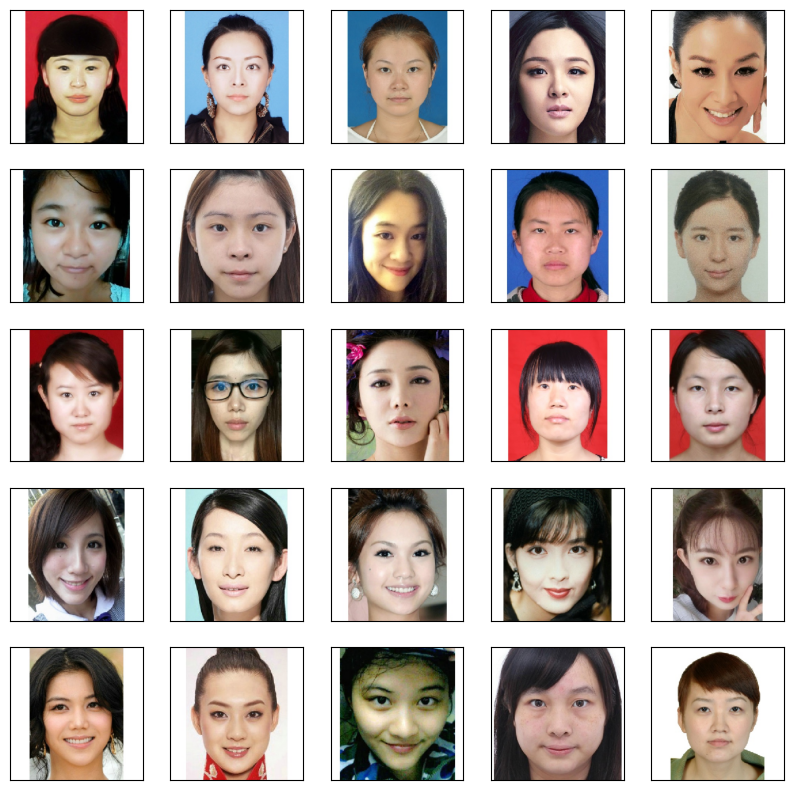

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

In [8]:
df_x.shape

(5500, 224, 224, 3)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1234)
x_train, x_valid, y_train, y_valid  =train_test_split(x_train, y_train, test_size=0.25, random_state=1234)

In [10]:
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3300, 224, 224, 3) (1100, 224, 224, 3) (1100, 224, 224, 3)
(3300,) (1100,) (1100,)


In [11]:
base_model = ResNet50(weights='imagenet', include_top=False)

2023-09-21 03:07:30.532087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 03:07:30.536757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 03:07:30.537390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 03:07:30.538507: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
predictions = layers.Dense(1, activation='linear')(x)  # 회귀 문제이므로 출력 뉴런은 1개, 활성화 함수는 linear
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
from tensorflow.keras import backend as K

def rmse_loss(y_true, y_pred):
    err = y_true - y_pred
    loss = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(err)))
    return loss

 
def plcc_loss(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    r = r_num / r_den
    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - r

def plcc_metric(y_true, y_pred):  
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-12
    return r_num / r_den

In [23]:
model.compile(optimizer='adam', loss='mse', metrics=plcc_metric)
history = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
104/104 [==============================] - 14s 101ms/step - loss: 343.2945 - plcc_metric: 0.4635 - val_loss: 0.7529 - val_plcc_metric: 0.3656
Epoch 2/20
104/104 [==============================] - 9s 91ms/step - loss: 0.0164 - plcc_metric: 0.5503 - val_loss: 0.2555 - val_plcc_metric: 0.4636
Epoch 3/20
104/104 [==============================] - 9s 91ms/step - loss: 0.0154 - plcc_metric: 0.5715 - val_loss: 0.0360 - val_plcc_metric: 0.5495
Epoch 4/20
104/104 [==============================] - 9s 91ms/step - loss: 0.0136 - plcc_metric: 0.6288 - val_loss: 0.0128 - val_plcc_metric: 0.6234
Epoch 5/20
104/104 [==============================] - 9s 91ms/step - loss: 0.0142 - plcc_metric: 0.6573 - val_loss: 0.0126 - val_plcc_metric: 0.6259
Epoch 6/20
104/104 [==============================] - 9s 91ms/step - loss: 0.0107 - plcc_metric: 0.6839 - val_loss: 0.0151 - val_plcc_metric: 0.6612
Epoch 7/20
104/104 [==============================] - 9s 91ms/step - loss: 0.0105 - plcc_metric: 0.727

In [24]:
predict = model.predict(x_test)

In [25]:
y_pred = predict.flatten()*5
y_true = y_test * 5

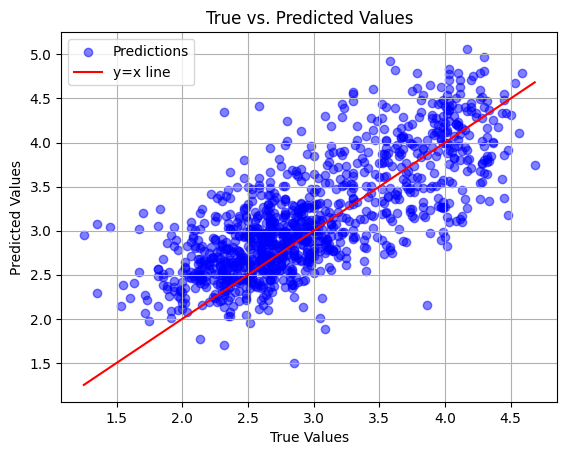

In [26]:
plt.scatter(y_true, y_pred, color='blue', alpha=0.5, label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='y=x line')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

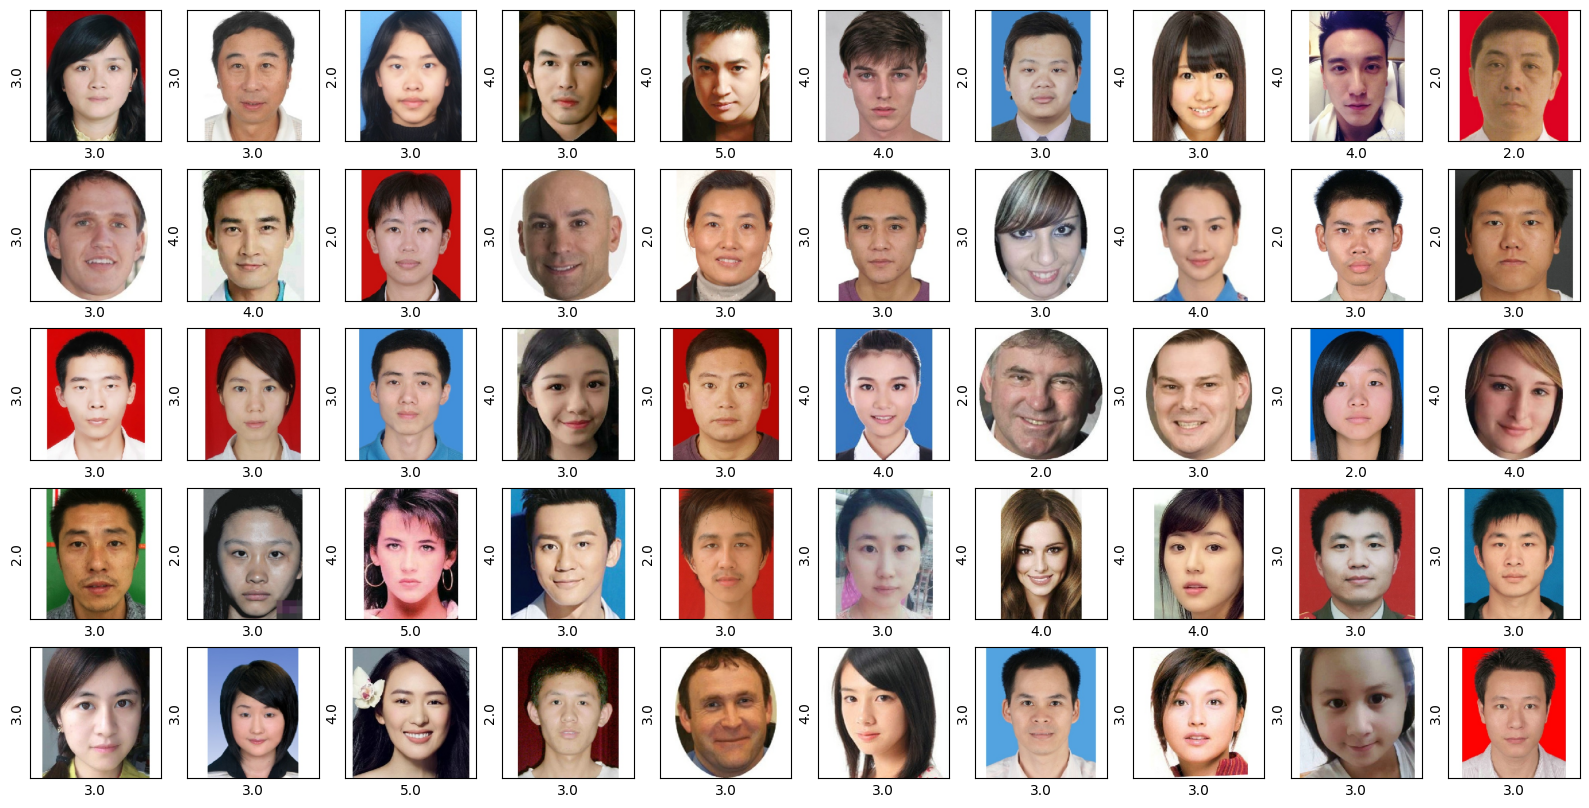

In [27]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.ylabel(y_true[i].round())
    plt.xlabel(y_pred[i].round())
plt.show()

In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))
rmse_val = rmse(y_true, y_pred)
mae_val = mae(y_true, y_pred)

print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")

RMSE: 0.4944
MAE: 0.3848


In [29]:
def pearson_correlation(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]
correlation = pearson_correlation(y_true, y_pred)
print(f"Pearson Correlation Coefficient: {correlation:.4f}")

Pearson Correlation Coefficient: 0.7511


In [30]:
y_pred1 = y_pred.round()
y_true1 = y_true.round()

In [31]:
np.mean(y_pred1==y_true1)

0.6309090909090909